In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.preprocessing import MinMaxScaler

from src.embedding_model import EmbeddingModel, EmbeddingTokenizer
from src.embedding_model.chunker import (
    parse_and_split_paragraphs_on_max_length_on_sentence,
)
from src.embedding_model.embed import embed_plaintext_for_document

Her importerer vi inn tekst for litt over 4000 dokumenter fra Kudos-databasen. Dette omfatter årsrapporter og tildelingsbrev.

In [2]:
with open("all_plaintexts_decompressed.pkl", "rb") as f:
    plaintexts = pickle.load(f)

Hvis vi undersøker dokumentene der vi ikke klarer å hente ut tekst i Kudos ser vi at det ikke er noe sjans for at vi får ut tekst uansett (kanskje fordi det er eksportert som pdf med bilder, eller skannet inn).

In [4]:
print(
    "Antall dokumenter uten tekst: ",
    len([name for name, plaintext in plaintexts.items() if len(plaintext) == 0]),
)
print(
    "Alle dokumenter uten tekst: ",
    [name for name, plaintext in plaintexts.items() if len(plaintext) == 0],
)

Antall dokumenter uten tekst:  158
Alle dokumenter uten tekst:  ['Årsrapport Riksmekleren 2014c49cf653-788e-4a50-bee9-6e68d581f551_22', 'Årsrapport Arbeidsretten 2014df95ddf7-7f02-440c-96f8-2a312e52cf32_98', 'Årsrapport Politiet 2016232af32e-15b2-4f1b-95db-cc45cc32c4bc_172', 'Årsrapport Riksmekleren 202005d10028-e83d-413c-a282-624a785cf6d0_213', 'Årsrapport Kulturrådet, Fond for lyd og bilde 201559411034-4bb3-460a-83c0-28fb8d630e6a_217', 'Årsrapport Klagenemnda for industrielle rettigheter 2016d16c6cc0-4fd7-4444-8251-c9ed2c060b97_271', 'Årsrapport Foreldreutvalget for grunnopplæringen og Foreldreutvalget for barnehager (FUG/FUB) 2019c2d0f99b-1af0-4fec-a7c4-873448877c13_304', 'Årsrapport (PDF)4efce63a-75c7-4517-b254-8eb77f03288a_306', 'Årsrapport Norsk lokalhistorisk institutt 20150659e54a-2f4f-454e-a0f8-a52a20fbad04_318', 'Årsrapport De nasjonale forskningsetiske komiteene 202018f5b4ae-1947-4476-bb0b-bdb9ea8d5a36_327', 'Årsrapport Riksmekleren 20163bbc2077-b967-4bc7-83ed-6a8085d62c89_3

Her undersøker vi hvordan teksten som er ekstrahert fra pdfen ser ut. Vi er spesielt interessert i hvordan teksten i pdfen er spaltet opp i paragrafer, siden vi ønsker å sende inn teksten på paragraf-nivå til KI-modellen.

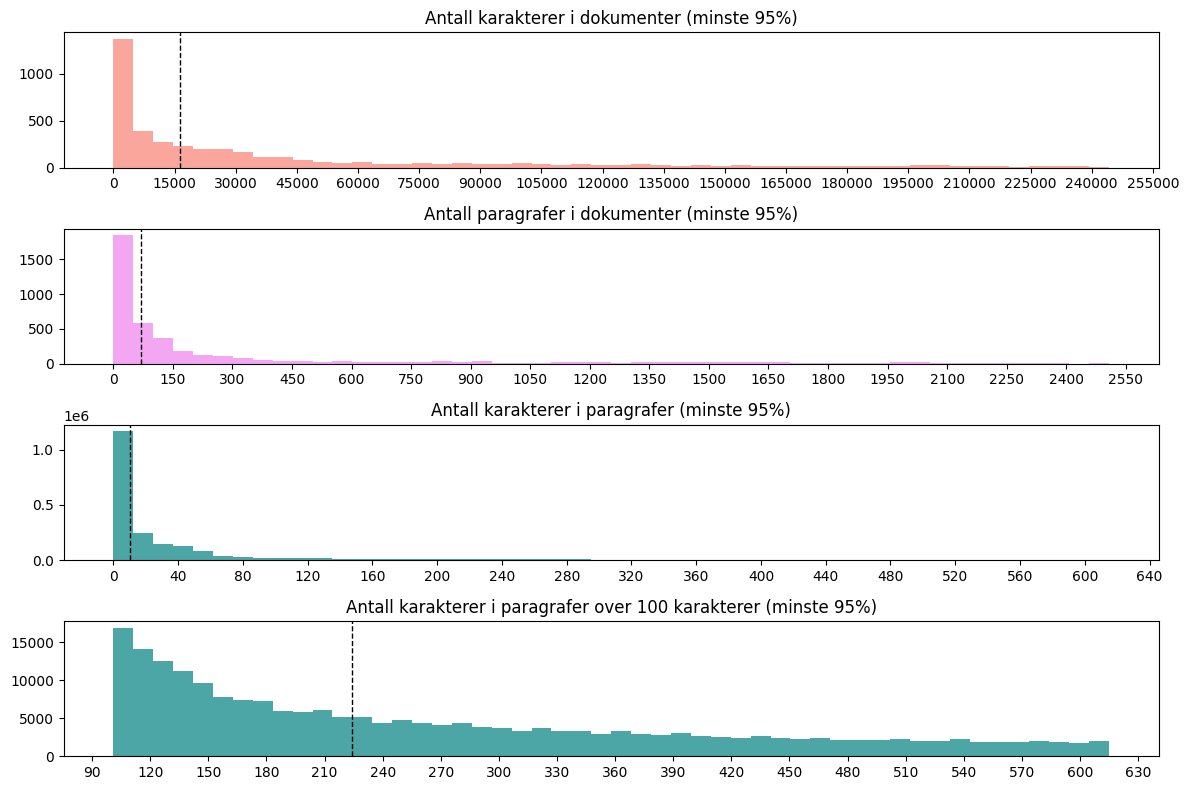

In [3]:
lengths_of_documents = [len(plaintext) for plaintext in plaintexts.values()]
percentile_95 = np.percentile(lengths_of_documents, 95)
filtered_lengths_of_documents = [
    length for length in lengths_of_documents if length <= percentile_95
]
number_of_paragraphs = [plaintext.count("\n\n") for plaintext in plaintexts.values()]
percentile_95 = np.percentile(number_of_paragraphs, 95)
filtered_number_of_paragraphs = [
    length for length in number_of_paragraphs if length <= percentile_95
]
lengths_of_paragraphs = [
    len(paragraph) for paragraph in "\n\n".join(plaintexts.values()).split("\n\n")
]
percentile_95 = np.percentile(lengths_of_paragraphs, 95)
filtered_lengths_of_paragraphs = [
    length for length in lengths_of_paragraphs if length <= percentile_95
]
chars_filtered_lengths_of_paragraphs = [
    length
    for length in lengths_of_paragraphs
    if length <= percentile_95 and length > 100
]

plt.figure(figsize=(12, 8))

# For each subplot...
for i, (data, title, color) in enumerate(
    [
        (
            filtered_lengths_of_documents,
            "Antall karakterer i dokumenter (minste 95%)",
            "salmon",
        ),
        (
            filtered_number_of_paragraphs,
            "Antall paragrafer i dokumenter (minste 95%)",
            "violet",
        ),
        (
            filtered_lengths_of_paragraphs,
            "Antall karakterer i paragrafer (minste 95%)",
            "teal",
        ),
        (
            chars_filtered_lengths_of_paragraphs,
            "Antall karakterer i paragrafer over 100 karakterer (minste 95%)",
            "teal",
        ),
    ],
    1,
):
    plt.subplot(4, 1, i)
    plt.hist(data, bins=50, color=color, alpha=0.7)
    plt.axvline(np.median(data), color="k", linestyle="dashed", linewidth=1)
    plt.title(title)

    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=20))

plt.tight_layout()
plt.show()

In [4]:
model = EmbeddingModel()
tokenizer = EmbeddingTokenizer()
model.load()
tokenizer.load()

Text(0.5, 1.0, 'Antall paragrafer over 80 karakterer i dokumenter')

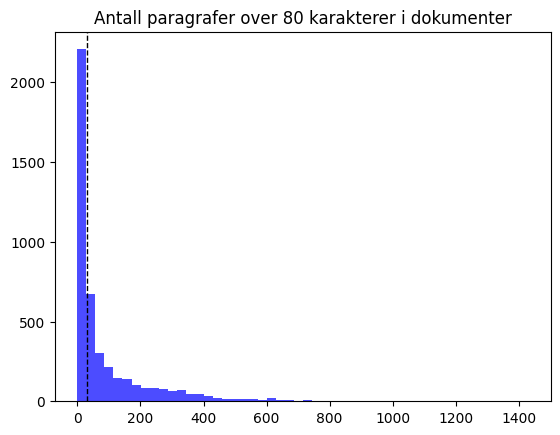

In [147]:
len_paragraphs_over_80_characters = [
    len(
        [
            x
            for x in parse_and_split_paragraphs_on_max_length_on_sentence(
                plaintext, tokenizer
            )
        ]
    )
    for plaintext in plaintexts.values()
]
plt.hist(len_paragraphs_over_80_characters, bins=50, color="blue", alpha=0.7)
plt.axvline(
    np.median(len_paragraphs_over_80_characters),
    color="k",
    linestyle="dashed",
    linewidth=1,
)
plt.title("Antall paragrafer over 80 karakterer i dokumenter")

In [70]:
current_directory = os.getcwd()
folder_path = os.path.join(current_directory, "paras")

files = os.listdir(folder_path)
paras = {}
start_document_no = 325
previous_documents_in_a_file = 25
documents_in_a_file = 10
ignore_documents = start_document_no + documents_in_a_file * (
    len(files) - int(start_document_no / previous_documents_in_a_file)
)
for n in range(
    ignore_documents,
    len(plaintexts),
    documents_in_a_file,
):
    for i, (name, plaintext) in enumerate(
        list(plaintexts.items())[n : n + documents_in_a_file]
    ):
        paras[name] = embed_plaintext_for_document(plaintext, model, tokenizer)
    with open(os.path.join(folder_path, f"paras_{n}.pkl"), "wb") as f:
        pickle.dump(paras, f)

KeyboardInterrupt: 

In [71]:
combined_data = {}
for filename in os.listdir(folder_path):
    if filename.endswith(".pkl"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            combined_data.update(data)

# Save the combined data to a new pickled file
output_file = "all_paras.pkl"
with open(output_file, "wb") as f:
    pickle.dump(combined_data, f)
paras = combined_data

In [81]:
# inn_text = [
#     "Innovasjon i offentlig sektor kan være en ny eller vesentlig endret tjeneste, produkt, prosess, organisering eller kommunikasjonsmåte. At innovasjonen er ny, betyr at den er ny for den aktuelle virksomheten, den kan likevel være kjent for og iverksatt i andre virksomheter."
# ]
# inn_text = [
# """Som en del av den stadige innsatsen for å fremme innovasjon innen offentlig sektor i Norge, har det vært flere betydningsfulle initiativ som har blitt lansert i de senere årene. Et eksempel på dette er regjeringens nylige lansering av Innovasjon Norge's program for å støtte oppstartsselskaper og fremme teknologisk innovasjon. Dette programmet har til hensikt å tilby finansiell støtte, veiledning og ressurser til bedrifter som utvikler banebrytende løsninger innenfor ulike sektorer.

# I tillegg har offentlige organer initiert flere prosjekter for å integrere digitale løsninger i tjenesteleveransen. Dette inkluderer utviklingen av digitale plattformer for bedre samhandling mellom offentlige institusjoner og borgerne, samt implementeringen av kunstig intelligens og maskinlæring for å effektivisere beslutningsprosesser og forbedre tjenestekvaliteten.

# Det har også vært et økende fokus på å fremme grønn innovasjon og bærekraftige løsninger innen offentlig sektor. Dette inkluderer initiativer for å redusere karbonavtrykket, fremme bruk av fornybar energi og støtte utviklingen av miljøvennlige transportalternativer.

# Gjennom disse innovative initiativene søker den norske offentlige sektoren aktivt å møte samfunnets behov på en effektiv, bærekraftig og fremtidsrettet måte."""
# ]
# inn_text = [
# """I den stadig skiftende og dynamiske verden av teknologi og forretningspraksis er innovasjon blitt kjernen i suksess for mange organisasjoner. Fra små oppstartsbedrifter til store multinasjonale selskaper, er evnen til å tenke utenfor boksen og implementere nyskapende løsninger blitt avgjørende. På tvers av sektorer og bransjer ser vi eksempler på radikale endringer drevet av innovasjon, fra disruptiv teknologi til banebrytende forretningsmodeller.

# Et sentralt trekk ved disse innovative initiativene er deres evne til å forstå og tilpasse seg endrede behov og preferanser i markedet. Dette kan manifestere seg gjennom utvikling av nye produkter og tjenester som utfordrer status quo, implementering av effektive prosesser som øker produktiviteten, eller etablering av partnerskap og samarbeid som muliggjør raskere og mer smidige reaksjoner på markedstrender.

# I tillegg til å fokusere på produkter og tjenester, handler innovasjon også om å omfavne nye måter å organisere og lede virksomheten på. Dette inkluderer å fremme en kultur for kreativitet og eksperimentering, å tilrettelegge for kunnskapsdeling og læring på tvers av organisasjonen, samt å være åpen for eksterne perspektiver og innsikt.

# På tross av de potensielle fordelene ved innovasjon, er det viktig å anerkjenne at det også kan være utfordrende og risikofylt. Endring kan møte motstand fra etablerte strukturer og interesser, og suksess er sjelden garantert. Derfor er det avgjørende å ha en strategisk tilnærming til innovasjon, som inkluderer grundig analyse av markedsmuligheter og trusler, samt kontinuerlig evaluering og tilpasning av strategier og tiltak.

# I sum er innovasjon en nøkkel til å sikre langsiktig bærekraft og konkurranseevne for organisasjoner i dagens komplekse og konkurranseutsatte miljø. Ved å være proaktiv og fleksibel i sin tilnærming, kan organisasjoner ikke bare overleve, men trives i en verden som stadig endrer seg."""
# ]
# inn_text = [
# """I dagens stadig skiftende landskap av tjenesteleveranse og organisasjonsstrukturer, er innovasjon en uunnværlig kraft for enhver virksomhet som ønsker å forbli konkurransedyktig. Gjennom å omfavne nye ideer og metoder, kan organisasjoner oppnå betydelige forbedringer i effektivitet og kvalitet. Et eksempel på dette er implementeringen av nye digitale plattformer for å lette samhandling og øke tilgjengeligheten av tjenester. Ved å omfavne disse teknologiske fremskrittene, kan bedrifter oppnå økt produktivitet og bedre kundeopplevelser.

# I tillegg til teknologiske innovasjoner, er det også viktig å erkjenne verdien av organisatoriske endringer. Gjennom å tilpasse arbeidsflyter og prosesser, kan virksomheter redusere unødvendig byråkrati og forbedre beslutningstaking. Et eksempel på dette er innføringen av flate hierarkier og desentraliserte beslutningsstrukturer, som gir ansatte større handlingsrom og mulighet til å ta initiativ.

# Videre kan innovasjon også komme i form av nye tilnærminger til produktutvikling. Ved å lytte nøye til kundens behov og ønsker, kan bedrifter utvikle produkter som bedre imøtekommer markedets krav. Dette kan inkludere alt fra designthinking workshops til prototyping og testing i sanntid. På denne måten kan organisasjoner redusere risiko og øke sjansene for suksess på markedet.

# Det er viktig å understreke at innovasjon ikke bare handler om å implementere nye ideer, men også om å kultivere en kultur for kontinuerlig forbedring. Dette innebærer å oppmuntre til eksperimentering og læring fra feil, samt å belønne kreativitet og nysgjerrighet blant ansatte. Gjennom å investere i opplæring og utvikling, kan virksomheter skape et miljø der innovasjon blomstrer og nye ideer blir realisert til fordel for både selskapet og dets kunder."""
# ]
# inn_text = [
#     """Vi har i år definert kultur og rammebetingelser for innovasjon. Vi ønsker å innovere ved å gjøre"""
# ]
inn_text = [
    """Rammebetingelser for innovasjon"""
]
# inn_text = ["Innovasjon"]
inn_text_embedding = model(tokenizer(inn_text))[0]

In [86]:
# inn_text = "Innovasjon i offentlig sektor kan være en ny eller vesentlig endret tjeneste, produkt, prosess, organisering eller kommunikasjonsmåte. At innovasjonen er ny, betyr at den er ny for den aktuelle virksomheten, den kan likevel være kjent for og iverksatt i andre virksomheter."
a1 = ["Vi har laget en helt ny ting som er kjempebra!"]
a2 = ["Innovasjon"]
a3 = ["我是阿德里安"]
a4 = [
    "\n%XG\x03)U¨QD\n\x03RJ\x03+XVWDG\x036SDUHE\nDQN\x03RJ\x031HVVHW\x036SDUHEDQN\x03\nIXVMRQHUWH\x03L\x03MDQXDU\x03\x15\x13\x14\x1b\x11\x03%DQNHQHV\x03YLUNVRPKHW\x03HU\x03YLGHUH\x10\nIºUW\x03XQGHU\x03QDYQHW\x035RPVGDO\x036SDUHEDQN\x11"
]
a1_embedding = model(tokenizer(a1))[0]
a2_embedding = model(tokenizer(a2))[0]
a3_embedding = model(tokenizer(a3))[0]
a4_embedding = model(tokenizer(a4))[0]

In [87]:
print("Lavere score er bedre")
print(cosine(inn_text_embedding, a1_embedding))
print(cosine(inn_text_embedding, a2_embedding))
print(cosine(inn_text_embedding, a3_embedding))
print(cosine(inn_text_embedding, a4_embedding))

Lavere score er bedre
0.1564239628557177
0.09659642313521555
0.2491370163695127
0.18940467377478287


In [3]:
# read the paras from pickle
with open("all_paras.pkl", "rb") as f:
    paras = pickle.load(f)

In [92]:
sims = {}
for key in paras:
    for i, val in enumerate(paras[key][1]):
        sims[paras[key][0][i] + ": " + key] = cosine(inn_text_embedding, val[0])

In [93]:
scaler = MinMaxScaler()
scaled_sims = scaler.fit_transform(np.array(list(sims.values())).reshape(-1, 1))
scaled_sims = {key: 1 - scaled_sims[i][0] for i, key in enumerate(sims.keys())}
sorted_sims = sorted(scaled_sims.items(), key=lambda x: x[1], reverse=True)
sorted_sims[:25]

[('Rammebetingelser ............................................................................................................. 57: Årsrapport Skatteetaten 201435267049-8702-49aa-aa87-24bc74778889_279',
  1.0),
 ('Innovasjon og kontinuerlig forbedring .......................................................................... 39: Årsrapport Difi 201613b66621-6915-4cc7-bc64-2e7d15e007eb_171',
  0.885631215060257),
 ('Rammebetingelser for samisk kulturminnevern ..................................................................... 135: Årsmelding Sametinget 20205efc91ba-bcfb-4a05-b4ea-f1862e5b9ab2_363',
  0.8740991170950634),
 ('- Teknisk gjennomgang av innovasjoner og løsninger som\nikke følger anerkjent norm.: Årsrapport Sjøfartsdirektoratet 2018e17150ff-eaa8-400b-b764-cca89b67adea_280',
  0.8696702320571006),
 ('Rammebetingelser for samisk kulturminnevern. ............................................................... 95: Årsrapport Sametinget 201773ca65f7-cc47-4ca5-8cf9-f64b73d957e3

In [91]:
print(sorted_sims[0][0])

Årsrapport Skatteetaten 201435267049-8702-49aa-aa87-24bc74778889_279: Rammebetingelser ............................................................................................................. 57
